In [1]:
# imports
import tensorflow as tf
import keras
import pandas as pd
import json
import gzip

# word to idx
import pickle

# our functions
import functions as f

import random


In [2]:
PATH = {}
PATH["dataset_classification"] = "dataset/classification/"
PATH["dataset_phase2"] = "dataset/phase2/"
PATH["dataset_labeling"] = "dataset/seq_labeling/"
PATH["music_reviews_train"] = PATH["dataset_classification"] + "music_reviews_train.json.gz"
PATH["music_reviews_dev"] = PATH["dataset_classification"] + "music_reviews_dev.json.gz"
PATH["music_reviews_test"] = PATH["dataset_classification"] + "music_reviews_test_masked.json.gz"
PATH["hard_cases"] = PATH["dataset_phase2"] + "phase2_testData-masked.json.gz"
#PATH["news"] = PATH["dataset_phase2"] + "review_polarity.tar.gz"
cat_dict = {0: "negative", 1:"positive"}

In [27]:
# load our model
model = keras.models.load_model('model/2022-4-18-23-34-42')

# load our word to idx
#### Thios is the original sequencer without stop words
#sequencer = pickle.load( open( "model/text_to_seq.p", "rb" ) )
sequencer = pickle.load( open( "model/text_to_seq_without_stop_words.p", "rb" ) )
sequencer = pickle.loads(sequencer)

In [28]:
# read in files
raw = f.readJson(PATH["hard_cases"])

Number of data:  3591


1176
0
average number of words in the sentence
74.71317181843497


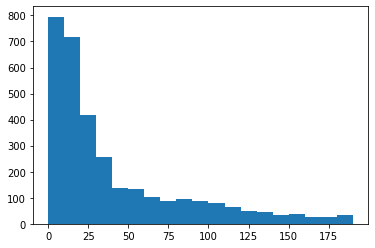

In [29]:
# some stat about the cases
length_of_sentencies_counter = []
for i in range(len(raw)):
    length_of_sentencies_counter.append(len(raw[i]["reviewText"].split()))
raw[0]["reviewText"]
import matplotlib.pyplot as plt
import numpy as np
print(max(length_of_sentencies_counter))
print(min(length_of_sentencies_counter))
bins = [10, 20, 30,40,50,70,80,90,100,150,200,300,400,500,600,700,800,1000]
plt.hist(length_of_sentencies_counter, bins = range(0, 200, 10))
print("average number of words in the sentence")
print(np.average(length_of_sentencies_counter))

In [30]:
test_x = []
test_y = []
test_com = []
test_group = []
for i in range(len(raw)):  
    test_x.append(raw[i]['reviewText'])
    test_com.append(raw[i]['category'])
    test_group.append(raw[i]['group'])

In [31]:
# original sequencer with mess
test_x_idx = sequencer.transform(test_x)

In [33]:
# padding apply
def sequence_pad(sequence, padding='pre', maxlen=50):
    res = tf.keras.preprocessing.sequence.pad_sequences(
        sequence,
        maxlen=maxlen,
        dtype='int32',
        padding=padding,
        truncating='pre',
        value=0.0)
    return res
padding = "post"
maxlen = 100

X_train_p = sequence_pad(test_x_idx, padding=padding, maxlen=maxlen)

# prediction
result = model.predict(X_train_p)
#print(result)

In [34]:
def sent_result_converter(number):
    threshold = 0.5
    if number<threshold:
        return "negative"
    if number>threshold:
        return "positive"

## Random samples


In [35]:
for i in random.sample(range(0, len(result)), 5):
    print("####", result[i], "---", test_x[i])

#### [0.9688262] --- This is a marvelous album.
#### [0.3588704] --- I should love this CD, the sound quality is amazing, all of the songs are incredibly varied and unique and i'm a big fan of the artist, but for some reason i just hate it. There is just something about it that i can't describe that feels incredibly wrong
#### [0.9918061] --- before you buy the jackal original soundtrack ... do  let the cover fool you . mezzanine is an easy album to get into to . in fact , `` dissolved girl '' is my sole reason for purchasing the album . i had to find this song . for starters , mezzanine introduces the techno `` lite '' listener to a large array of elements including real instruments and live vocals . nearly every track has a distinctive sound which gives the entire album great `` replay value . '' in particular , one track ( which has been edited for a popular medical drama ) is a masterpiece . if you 've never heard of massive attack then this is a great way to experience them first 

# Write to JSON, save and check it

In [36]:
keys = ["reviewText","sentiment","category"]

In [37]:
json_raw_data = []
for i in range(len(raw)):
    temp_data = []
    def_dict = dict()
    for c in keys:
        if c ==  "reviewText":
            def_dict[c] = str(test_x[i])
        if c ==  "sentiment":
            def_dict[c] = str(sent_result_converter(result[i]))
        if c ==  "category":
            def_dict[c] = str(test_com[i])   
    json_raw_data.append(def_dict) # ok this is very good, itsa opening with json.load
    
outFile = open('group16_hard_cases_raw.json', 'w')
for instance in json_raw_data:
      outFile.write(json.dumps(instance) + '\n')
outFile.close()

In [38]:
for line in gzip.open('group16_hard_cases_raw.json.gz'):
    review_data = json.loads(line)
    for key in review_data:
        print('"' + key +'": ' + str(review_data[key]))
    break

"reviewText": It's the shit
"sentiment": positive
"category": slang
